# Latent diffusion

This tutorial demonstrates how to generate images with latent diffusion models such as Stable Diffusion, Flux and Sana.

In [1]:
# !pip install diffusers transformers accelerate

In [2]:
import torch

from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

from azula.guidance import CFGDenoiser
from azula.nn.utils import cpu_offload
from azula.plugins import sd, flux, sana
from azula.sample import ABSampler  # Adams-Bashforth sampler

device = "cuda"

In [3]:
_ = torch.manual_seed(42)

In [4]:
def postprocess(x):
    return torch.clip((x + 1) / 2, min=0, max=1)

## Stable Diffusion

In [5]:
denoiser, autoencoder, textencoder = sd.load_model("sd_1.5")
denoiser, autoencoder = denoiser.to(device), autoencoder.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
with torch.no_grad(), cpu_offload(textencoder, device):
    prompt = textencoder("an astronaut riding a horse in space")
    null = textencoder("")

We first try without classifier-free guidance (CFG). The resulting images do not follow the prompt well and have poor composition.

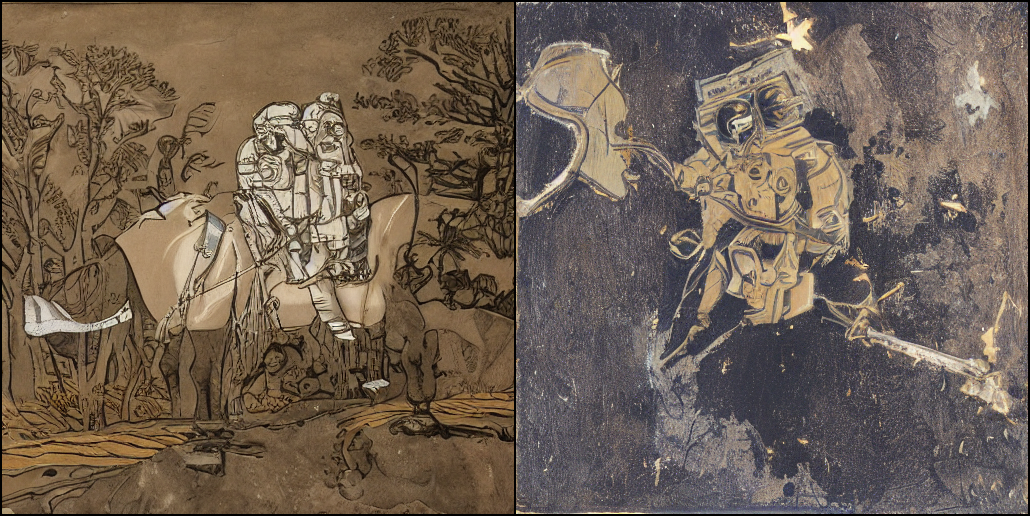

In [7]:
sampler = ABSampler(denoiser, steps=16).to(device)

z1 = sampler.init((2, 4, 64, 64))  # B C H W
z0 = sampler(z1, **prompt)

with torch.no_grad():
    x = autoencoder.decode(z0)

to_pil_image(make_grid(postprocess(x)))

Now with classifier-free guidance, which should boost prompt fidelity and image quality.

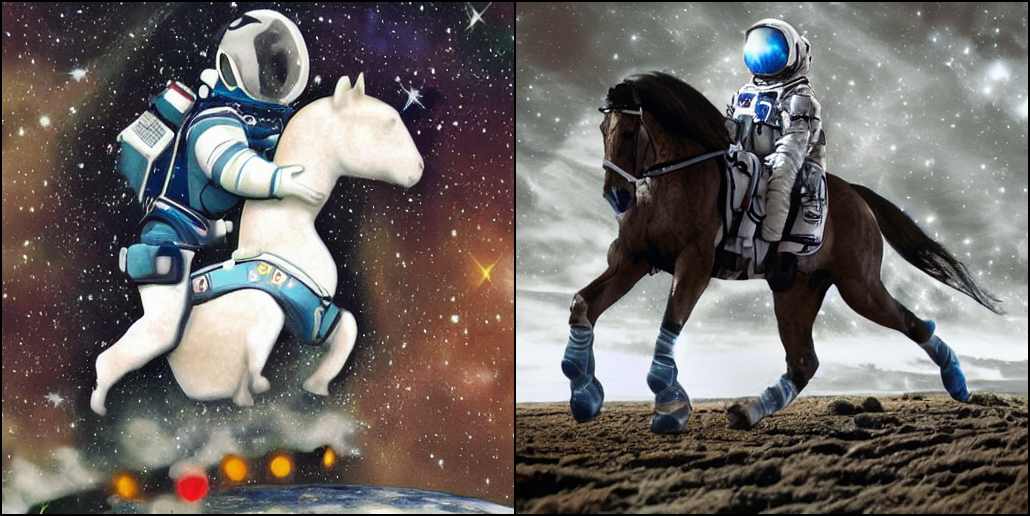

In [8]:
sampler = ABSampler(CFGDenoiser(denoiser), steps=16).to(device)

z1 = sampler.init((2, 4, 64, 64))
z0 = sampler(z1, positive=prompt, negative=null, guidance=3.0)

with torch.no_grad():
    x = autoencoder.decode(z0)

to_pil_image(make_grid(postprocess(x)))

In [9]:
del denoiser, autoencoder, textencoder

## Flux

In [10]:
denoiser, autoencoder, textencoder = flux.load_model()
denoiser, autoencoder = denoiser.to(device), autoencoder.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
with torch.no_grad(), cpu_offload(textencoder, device):
    prompt = textencoder("a forest with a big warning sign that says 'Flux'")

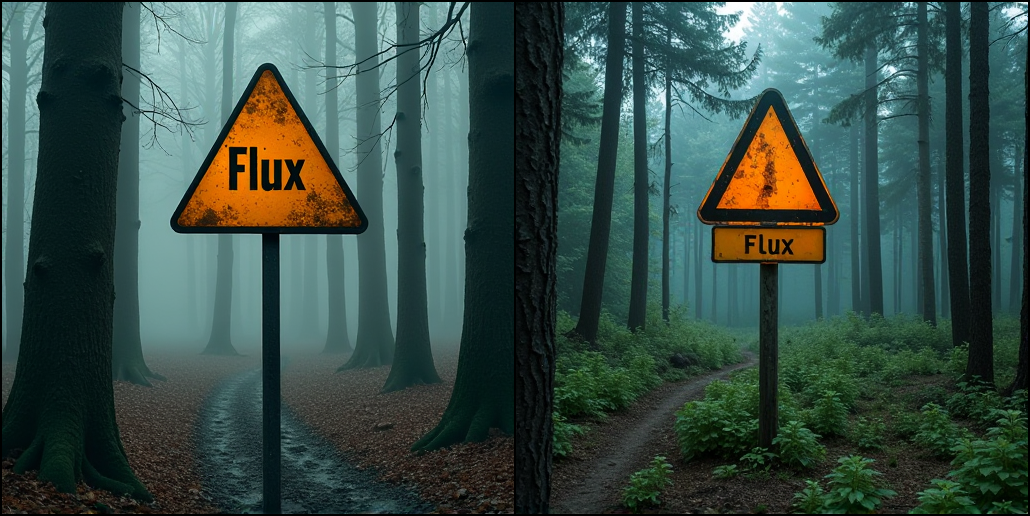

In [12]:
sampler = ABSampler(denoiser, steps=16).to(device)

z1 = sampler.init((2, 32, 32, 64))  # B H W C
z0 = sampler(z1, **prompt)

with torch.no_grad():
    x = autoencoder.decode(z0)

to_pil_image(make_grid(postprocess(x)))

In [13]:
del denoiser, autoencoder, textencoder

## Sana

In [14]:
denoiser, autoencoder, textencoder = sana.load_model("sana_1.6b_512")
denoiser, autoencoder = denoiser.to(device), autoencoder.to(device)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
with torch.no_grad(), cpu_offload(textencoder, device):
    prompt = textencoder("a cyberpunk cat with a neon sign that says 'Sana'")
    null = textencoder("")

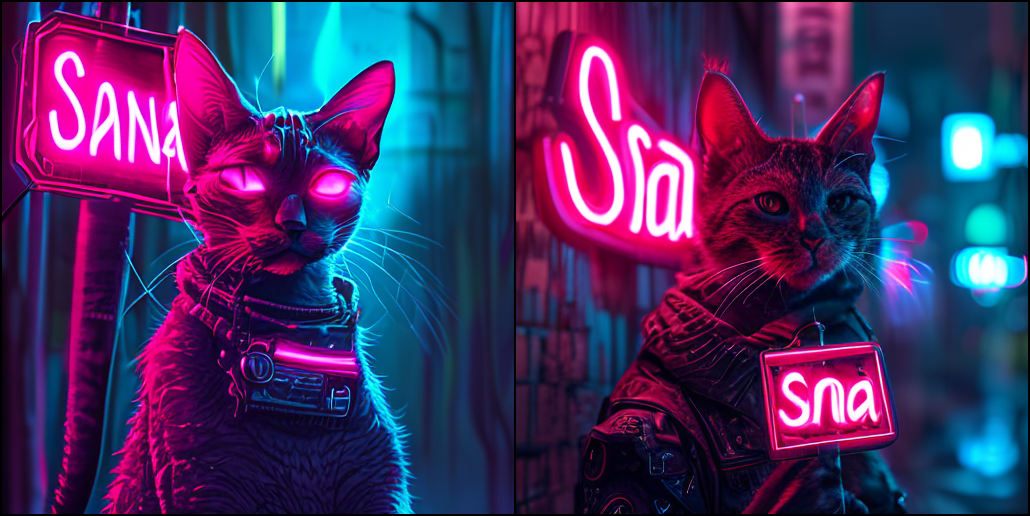

In [16]:
sampler = ABSampler(CFGDenoiser(denoiser), steps=16).to(device)

z1 = sampler.init((2, 32, 16, 16))
z0 = sampler(z1, positive=prompt, negative=null, guidance=3.0)

with torch.no_grad():
    x = autoencoder.decode(z0)

to_pil_image(make_grid(postprocess(x)))